# Applying Pretrained Networks to Empirical Data

First of all, we have to load all packages:

In [11]:
import sys

sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import keras

import bayesflow as bf

from dmc import dmc_helpers, DMC

After training the networks, the checkpoints are stored as `.keras`-files. In our workflow, we trained four sets of networks on either *initial priors* or *updated priors* and with either fixed or estimated trial-to-trial variability of the non-decision time. All corresponding networks can be found in the folder `training_checkpoints/`:

* `initial_priors_sdr_fixed.keras`
* `initial_priors_sdr_estimated.keras`
* `updated_priors_sdr_fixed.keras`
* `updated_priors_sdr_estimated.keras`


You can choose which network you like to apply by loading the corresponding file, e.g.:

In [12]:
approximator = keras.saving.load_model('../training_checkpoints/updated_priors_sdr_estimated.keras')

/home/administrator/miniforge3/envs/bf_new/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 159 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


The `approximator` contains everything we need to get posterior samples for a given data set. Next, we load a data set:

In [45]:
data = pd.read_csv('../empirical_data/experiment_data_narrow.csv')


Our data set contains the reaction times (`rt`) and accuracy (`accuracy`) from a standard Eriksen Flanker Task. The variable `congruency_num` denotes the congruency of flanker and target stimuli with 0 indicating congruent and 1 indicating incongruent stimuli. Let's check if the RT distributions are as expected:

<Axes: xlabel='rt', ylabel='Density'>

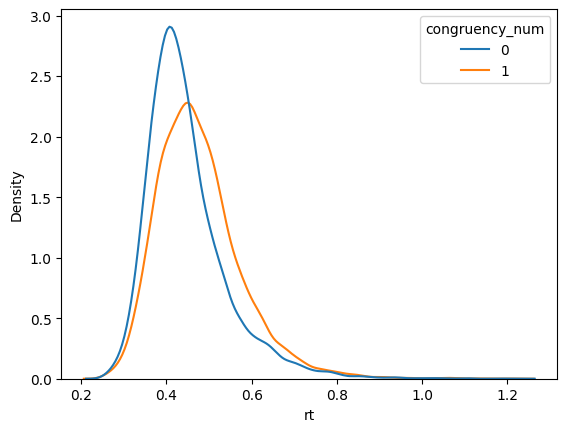

In [46]:
sns.kdeplot(data, x='rt', hue='congruency_num')

As anticipated, the reaction time is larger in incongruent conditions compared to congruent conditions. 

We want to apply the DMC to this data set and draw posterior samples for each individual in the data set. Before applying the approximator, we have to make sure that the data has the correct format (dictionary with one entry for each variable). To do so, we can apply the helper function `format_empirical_data`:

In [48]:
data_dict = dmc_helpers.format_empirical_data(data, var_names = ['rt', 'accuracy', 'congruency_num'])

data_dict

{'rt': array([[[0.469 ],
         [0.454 ],
         [0.4345],
         ...,
         [0.43  ],
         [0.492 ],
         [0.539 ]]]),
 'accuracy': array([[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]]),
 'conditions': array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [1.],
         [1.]]]),
 'num_obs': array([[24847]])}

However, this treats the whole data set as one participant. If we want to apply the approximator for each individual seperately, we can simply iterate across all participants:

In [49]:
ids = data['participant'].unique()

post_samples = list()

for id in ids:

    data_id = data[data['participant'] == id]

    data_id_dict = dmc_helpers.format_empirical_data(data_id, var_names = ['rt', 'accuracy', 'congruency_num'])

    post_samples_id = approximator.sample(conditions = data_id_dict, num_samples = 1000)

    post_samples_id_np={k: v.flatten() for k, v in post_samples_id.items()}
        
    post_samples_id_df=pd.DataFrame(post_samples_id_np)

    post_samples_id_df['participant'] = id

    post_samples.append(pd.DataFrame(post_samples_id_df))

In [50]:
post_samples_df = pd.concat(post_samples)

In [51]:
post_samples_df

,A,tau,mu_c,mu_r,b,sd_r,participant
0,14.311186,138.270523,0.631486,392.023315,74.871452,35.120434,6361
1,18.514927,149.133957,0.570490,390.227997,74.574516,32.339153,6361
2,16.061138,105.542130,0.607598,380.434174,79.440231,33.089497,6361
3,19.759701,95.969536,0.624281,403.777893,69.564697,38.041199,6361
4,18.868530,88.436699,0.623102,392.532898,75.554550,37.132027,6361
...,...,...,...,...,...,...,...
995,15.530549,86.197197,0.449223,366.244415,72.312439,34.370007,1582
996,15.991253,53.927849,0.542809,363.152466,70.571854,30.910143,1582
997,26.253880,38.892303,0.585121,368.797729,79.641998,40.625698,1582
998,18.093021,53.935326,0.559471,376.125549,72.442833,46.810341,1582


Instead of iterating across all participants manually, we can use the function `fit_empirical_data()` that does alle these steps at once:

In [54]:
post_samples = dmc_helpers.fit_empirical_data(data, approximator=approximator, id_label='participant')

Taken together, applying the trained networks boils down to these simple steps:

1. Load your data

In [56]:
data = pd.read_csv('../empirical_data/experiment_data_narrow.csv')


2. Load the approximator

In [57]:
approximator = keras.saving.load_model('../training_checkpoints/updated_priors_sdr_estimated.keras')

/home/administrator/miniforge3/envs/bf_new/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 159 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3. Draw posterior samples

In [58]:
post_samples = dmc_helpers.fit_empirical_data(data, approximator=approximator, id_label='participant')